In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'x-small', 'ytick.labelsize': 'x-small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm
import os
import pickle

# Fetch precomputed RF centers of sparse and dense sessions

In [2]:
FULLS = ['07317162', '48834689']
TILES = [
    '39491886', '48683828', '02187077', '19889837',
    '22652138', '25394938', '27832912', '31080823',
    '05454007', '09690755', '76995123', '98782621',
    '07586668', '80605801', '37721134', '39666903',
]

In [3]:
def vals2map(vals):
    if vals.shape==(256,):
        v_map = vals.reshape(16, 16).copy()
    elif vals.shape==(1024,):
        offsets = [(0, 0), (1, 0), (1, 1), (0, 1)]
        assert vals.shape==(1024,)
        v_map = np.full((32, 32), fill_value=np.nan)
        for i, (y, x) in enumerate(offsets):
            v_map[y::2, x::2] = vals[i*256:(i+1)*256].reshape(16, 16)
    else:
        raise ValueError(f"Incorrect shape: {vals.shape}")
    return v_map

## Fetch sparse sessions recorded from the full chip

In [4]:
freq = 64

xs, ys, angs, eccs = {}, {}, {}, {}
for session_id in FULLS:
    with open(f'../cache/RF.fits/RF.fit_{session_id}_[{freq}Hz].pkl', 'rb') as f:
        saved = pickle.load(f)

    _xs = np.arange(16)/16*6.8
    _ys = np.arange(16)/16*7.4
    _ys, _xs = np.meshgrid(_ys, _xs, indexing='ij')
    fvus = vals2map(saved['fvus'])
    rf_xs = vals2map(saved['params_s'][:, 1])
    rf_ys = vals2map(saved['params_s'][:, 2])
    mask = fvus<0.8
    _angs = np.arctan2(rf_xs, rf_ys)/np.pi*180
    _eccs = (rf_xs**2+rf_ys**2)**0.5

    if session_id=='07317162':
        tag = 'Day 36'
    if session_id=='48834689':
        tag = 'Day 62'
    xs[tag] = _xs[mask]
    ys[tag] = _ys[mask]
    angs[tag] = _angs[mask]
    eccs[tag] = _eccs[mask]

## Fetch and stitch dense sessions

In [5]:
xs, ys, angs, eccs = {}, {}, {}, {}
masks = {}
for session_id in FULLS:
    with open(f'../cache/RF.fits/RF.fit_{session_id}_[{freq}Hz].pkl', 'rb') as f:
        saved = pickle.load(f)

    _xs = np.arange(16)/16*6.8
    _ys = np.arange(16)/16*7.4
    _ys, _xs = np.meshgrid(_ys, _xs, indexing='ij')
    fvus = vals2map(saved['fvus'])
    rf_xs = vals2map(saved['params_s'][:, 1])
    rf_ys = vals2map(saved['params_s'][:, 2])
    mask = fvus<0.8
    _angs = np.arctan2(rf_xs, rf_ys)/np.pi*180
    _eccs = (rf_xs**2+rf_ys**2)**0.5

    if session_id=='07317162':
        tag = 'Day 36'
    if session_id=='48834689':
        tag = 'Day 62'
    xs[tag] = _xs
    ys[tag] = _ys
    masks[tag] = mask
    angs[tag] = _angs
    eccs[tag] = _eccs

## Evaluate chronic stability

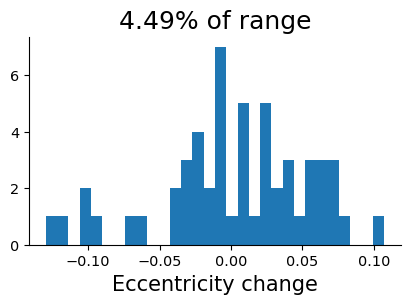

In [6]:
mask = masks['Day 36']&masks['Day 62']
deltas = eccs['Day 62'][mask]-eccs['Day 36'][mask]
vals = np.concatenate([eccs['Day 36'][masks['Day 36']], eccs['Day 62'][masks['Day 62']]])
v_range = vals.max()-vals.min()

_, ax = plt.subplots()
ax.hist(deltas, 30)
ax.set_xlabel('Eccentricity change')
ax.set_title('{:.2%} of range'.format((deltas**2).mean()**0.5/v_range))
plt.show()

# Find cortical coordinate projection that aligns with eccentricity

In [7]:
for tag in masks:
    xs[tag] = xs[tag][masks[tag]]
    ys[tag] = ys[tag][masks[tag]]
    angs[tag] = angs[tag][masks[tag]]
    eccs[tag] = eccs[tag][masks[tag]]

w, *_ = np.linalg.lstsq(np.stack([
    np.concatenate(list(xs.values())),
    np.concatenate(list(ys.values())),
    np.ones(sum(len(v) for v in eccs.values())),
], axis=1), np.concatenate(list(eccs.values())), rcond=None)
n_vec = np.array([w[0], w[1]])
n_vec /= (n_vec**2).sum()**0.5
wx, wy = n_vec

print('Direction {:.1f} deg'.format(np.arctan2(wy, wx)/np.pi*180))

Direction 154.5 deg


## Fetch and stitch dense sessions

In [8]:
tag = 'Day 41-48'

fvus = np.full((128, 128), fill_value=np.nan)
rf_xs = np.full((128, 128), fill_value=np.nan)
rf_ys = np.full((128, 128), fill_value=np.nan)
for i in range(4):
    for j in range(4):
        session_id = TILES[4*i+j]
        with open(f'../cache/RF.fits/RF.fit_{session_id}_[{freq}Hz].pkl', 'rb') as f:
            saved = pickle.load(f)

        fvus[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['fvus'])
        rf_xs[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['params_s'][:, 1])
        rf_ys[32*i:32*(i+1), 32*j:32*(j+1)] = vals2map(saved['params_s'][:, 2])
mask = fvus<0.8
angs[tag] = (np.arctan2(rf_xs, rf_ys)/np.pi*180)[mask]
eccs[tag] = ((rf_xs**2+rf_ys**2)**0.5)[mask]

_xs = np.arange(128)/128*6.8/2
_ys = np.arange(128)/128*7.4/2
_ys, _xs = np.meshgrid(_ys, _xs, indexing='ij')
xs[tag] = _xs[mask]
ys[tag] = _ys[mask]

## Visualize retinotopy projections

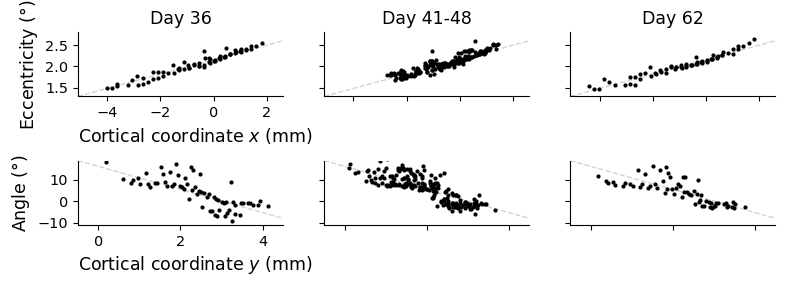

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(9, 2.5), gridspec_kw={'hspace': 1})
for i in range(2):
    for j in range(3):
        if j==0:
            tag = 'Day 36'
        if j==1:
            tag = 'Day 41-48'
        if j==2:
            tag = 'Day 62'
        if i==0:
            coords = wx*xs[tag]+wy*ys[tag]
            vals = eccs[tag]
        if i==1:
            coords = wy*xs[tag]-wx*ys[tag]
            vals = angs[tag]
        if j==1:
            idxs = np.random.default_rng().choice(len(coords), 200)
            coords = coords[idxs]
            vals = vals[idxs]

        ax = axes[i, j]
        ax.scatter(coords, vals, s=4, color='black')
        if i==0:
            ax.plot([-5.1, 2.6], [1.3, 2.6], linewidth=1, color='lightgray', zorder=0, linestyle='--')
            ax.set_xlim([-5.1, 2.6])
            ax.set_ylim([1.3, 2.8])
        if i==1:
            ax.plot([-0.5, 4.5], [19, -8], linewidth=1, color='lightgray', zorder=0, linestyle='--')
            ax.set_xlim([-0.5, 4.5])
            ax.set_ylim([-11, 19])
        if j>0:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        if i==0:
            ax.set_title(tag, fontsize='small')
ax = axes[0, 0]
ax.set_xlabel('Cortical coordinate $x$ (mm)', loc='left', fontsize='small')
ax.set_ylabel(r'Eccentricity ($\degree$)', fontsize='small')
ax = axes[1, 0]
ax.set_xlabel('Cortical coordinate $y$ (mm)', loc='left', fontsize='small')
ax.set_ylabel(r'Angle ($\degree$)', fontsize='small')
fig.savefig('../figures/retinotopy.stability.svg')

plt.show()